In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, accuracy_score, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Modèle Logit
## Import des données

In [54]:
df = pd.read_csv('../data/df_logit_xgb.csv',sep = ',')

In [55]:
df.head()

,cd_op,MT_CHA_PIV,arrete,mt_rev_dispo,date_entree_defaut,niv_gravite_mtf_dfs,CD_POST_BIEN_PFI,cum_rec,dls_mep_entree_def,ANC_PRO_MAX_PFI,...,MT_EAD_DNE_CHR_d_binned,MT_EAD_RESID_binned,niv_gravite_mtf_dfs_binned,MT_REV_PFI_binned,MT_FMG_binned,ANC_PRO_MAX_PFI_binned,EAD_1an_avant_def_binned,CD_DNE_CHR_LGD_SAIN_binned,max_age_ctx_binned,TX_APPOR_binned
0,I860708600,0.0,2017-01-31,1413.20,2017-01-16,1,1,4173.79,369.366667,84.0,...,"(-inf, 9153.62)","(-inf, 59872.16)","[0.50, inf)",1,1,2,"(-inf, 61998.46)",2,"[319.90, inf)","(-inf, 0.33)"
1,I950404213,0.0,2017-03-31,3119.57,2017-03-15,0,1,0.00,265.100000,203.0,...,"(-inf, 9153.62)","(-inf, 59872.16)","(-inf, 0.50)",1,1,2,"(-inf, 61998.46)",1,"[319.90, inf)","(-inf, 0.33)"
2,I950706618,0.0,2016-08-31,0.00,2016-01-28,0,3,0.00,247.666667,42.0,...,"(-inf, 9153.62)","(-inf, 59872.16)","(-inf, 0.50)",1,1,1,"(-inf, 61998.46)",1,"[319.90, inf)","(-inf, 0.33)"
3,I950901248,0.0,2017-01-31,0.00,2017-01-27,0,1,0.00,259.066667,166.0,...,"(-inf, 9153.62)","(-inf, 59872.16)","(-inf, 0.50)",1,1,2,"(-inf, 61998.46)",2,"[319.90, inf)","[0.33, inf)"
4,I960300578,0.0,2016-06-30,0.00,2016-06-28,0,1,0.00,246.133333,3.0,...,"(-inf, 9153.62)","(-inf, 59872.16)","(-inf, 0.50)",1,1,1,"(-inf, 61998.46)",1,"[319.90, inf)","[0.33, inf)"


In [56]:
df['arrete'] = pd.to_datetime(df['arrete'])

## Récupération des variables sélectionnées

In [57]:
df = df[['CD_MTF_DFC', 'niv_gravite_mtf_dfs', 'CD_MTF_ENE_CTX',
       'ANC_PRO_MAX_PFI_binned', 'nb_empr_ope', 'CD_DNE_CHR_LGD_SAIN_binned', 'CD_POST_BIEN_PFI',
         'DET', 'arrete', 'cd_op']]

## Split des données : Entraînement / Validation

In [58]:
# On prend soin d'écarter les données pendant la période Covid

df_validation = df[df['arrete']>"2020-06-30"]
data = df[df['arrete']<"2019-12-31"]

In [59]:
X_train = data.select_dtypes(exclude = 'datetime').copy()
X_test = df_validation.select_dtypes(exclude = 'datetime').copy()

In [60]:
y_train = X_train['DET']
X_train.drop(columns = 'DET', inplace = True)

In [61]:
y_test = X_test['DET']
X_test.drop(columns = 'DET', inplace = True)

In [62]:
X_train.drop(columns = ['cd_op'], inplace = True)
X_test.drop(columns = ['cd_op'], inplace = True)

## Modélisation

In [63]:
model = LogisticRegression(penalty='l1', solver='liblinear')
model = model.fit(X_train, y_train)

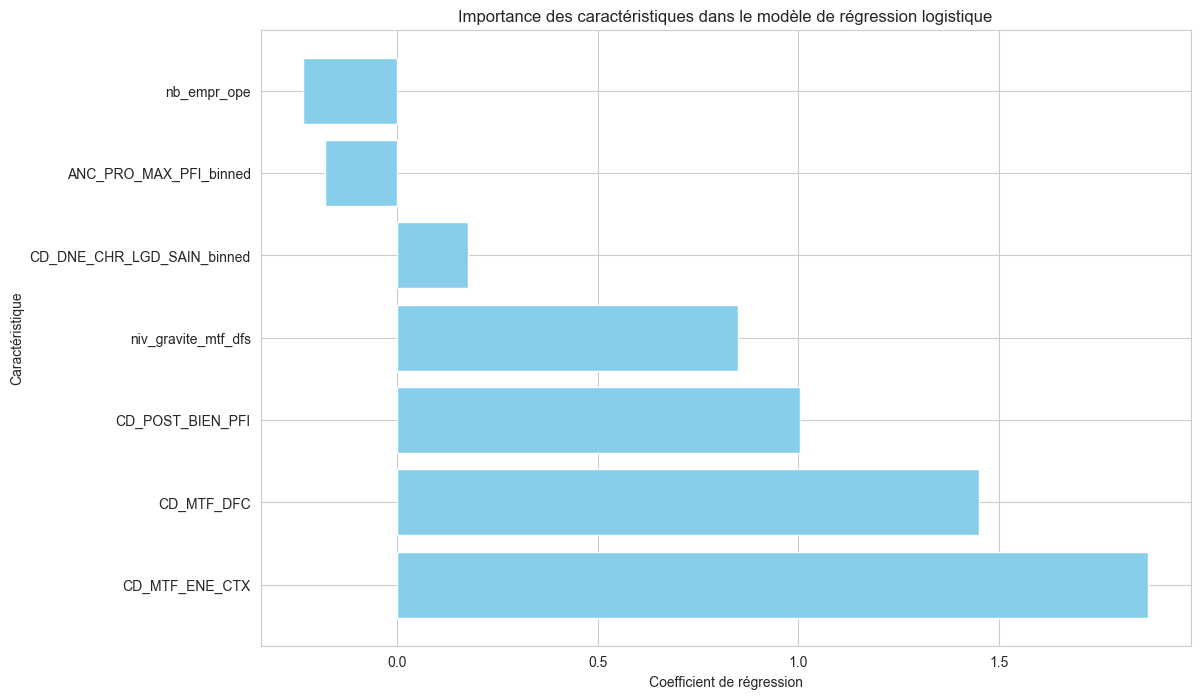

In [64]:
coefficients = model.coef_[0]

feature_names = X_train.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

feature_importance_df['Abs_Coefficient'] = feature_importance_df['Coefficient']
feature_importance_df = feature_importance_df.sort_values(by='Abs_Coefficient', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Abs_Coefficient'], color='skyblue')
plt.xlabel('Coefficient de régression')
plt.ylabel('Caractéristique')
plt.title('Importance des caractéristiques dans le modèle de régression logistique')
plt.show()

In [65]:
feature_importance_df

,Feature,Coefficient,Abs_Coefficient
2,CD_MTF_ENE_CTX,1.871918,1.871918
0,CD_MTF_DFC,1.451133,1.451133
6,CD_POST_BIEN_PFI,1.004374,1.004374
1,niv_gravite_mtf_dfs,0.848988,0.848988
5,CD_DNE_CHR_LGD_SAIN_binned,0.176523,0.176523
3,ANC_PRO_MAX_PFI_binned,-0.179228,-0.179228
4,nb_empr_ope,-0.234559,-0.234559


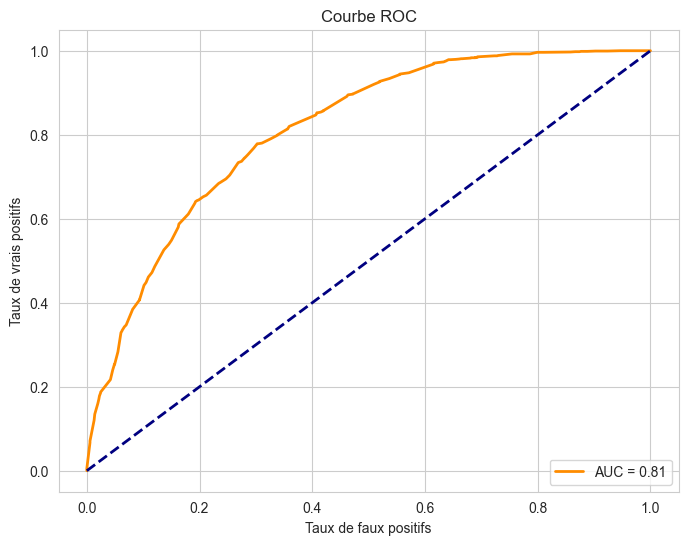

In [66]:
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

In [67]:
y_true = y_test
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_true, y_pred)

# Calcul des métriques à partir de la matrice de confusion
true_positive = conf_matrix[1][1]
false_positive = conf_matrix[0][1]
true_negative = conf_matrix[0][0]
false_negative = conf_matrix[1][0]

# Calcul des métriques
accuracy = accuracy_score(y_true, y_pred)
specificity = true_negative / (true_negative + false_positive)
sensitivity = true_positive / (true_positive + false_negative)

print("Précision (Accuracy): {:.2f}".format(accuracy))
print("Spécificité (Specificity): {:.2f}".format(specificity))
print("Sensibilité (Sensitivity): {:.2f}".format(sensitivity))

Précision (Accuracy): 0.77
Spécificité (Specificity): 0.80
Sensibilité (Sensitivity): 0.64


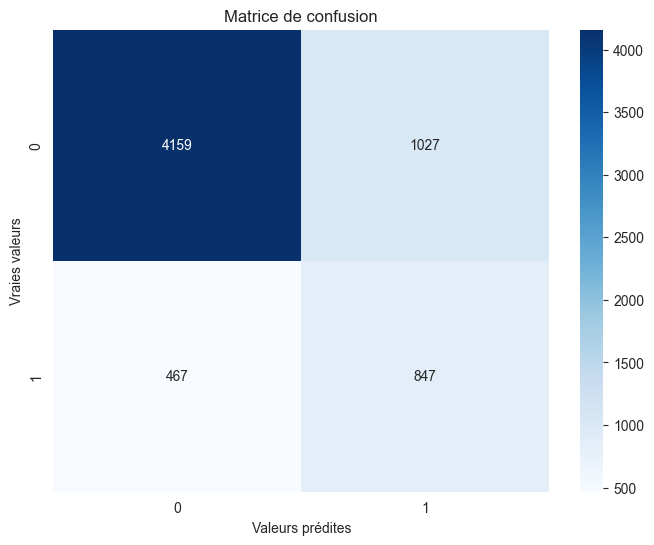

In [68]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valeurs prédites')
plt.ylabel('Vraies valeurs')
plt.title('Matrice de confusion')
plt.show()